## Oksana Kitaychik - Model Validation: LSVM (Code / Appendix 2)
### Advanced Risk Management

Let us first import necessary python libraries and introduce a few general codes/functons that I will be using for model validation below:

In [71]:
import numpy as np
from scipy.stats import norm

%matplotlib inline
import matplotlib.pyplot as plt

import math
import numpy.random as rnd


In [72]:
def blackscholes_price(K, T, S, vol, r=0, q=0, callput='call'):
    """Compute the call/put option price in Black-Scholes model
    
    Parameters
    ----------
    K: scalar or array_like
        The strike of the option.
    T: scalar or array_like
        The maturity of the option.
    S: scalar or array_like
        The spot price of the underlying security.
    vol: scalar or array_like
        The implied Black-Scholes volatility.
    callput: str
        Must be either 'call' or 'put'

    Returns
    -------
    price: scalar or array_like
        The price of the option.

    Examples
    --------
    >>> blackscholes_price(95, 0.25, 100, 0.2, r=0.05, callput='put')
    1.5342604771222823
    """
    F = S*np.exp((r-q)*T)
    w = vol**2*T
    d1 = (np.log(F/K)+0.5*w)/np.sqrt(w)
    d2 = d1 - np.sqrt(w)
    callput = callput.lower()
    if callput == 'call':
        opttype = 1
    elif callput == 'put':
        opttype = -1
    else:
        raise ValueError('The value of callput must be either "call" or "put".')
    price = (opttype*F*norm.cdf(opttype*d1)-opttype*K*norm.cdf(opttype*(d2)))*np.exp(-r*T)
    return price

In [73]:
# all inputs must be scalar
def blackscholes_impv_scalar(K, T, S, value, r=0, q=0, callput='call', tol=1e-6, maxiter=500):
    """Compute implied vol in Black-Scholes model
    
    Parameters
    ----------
    K: scalar
        The strike of the option.
    T: scalar
        The maturity of the option.
    S: scalar
        The spot price of the underlying security.
    value: scalar
        The value of the option
    callput: str
        Must be either 'call' or 'put'

    Returns
    -------
    vol: scalar
        The implied vol of the option.
    """
    if (K <= 0) or (T <= 0):
        return np.nan
    F = S*np.exp((r-q)*T)
    K = K/F
    value = value*np.exp(r*T)/F
    callput = callput.lower()
    if callput not in ['call', 'put']:
        raise ValueError('The value of "callput" must be either "call" or "put"')
    opttype = 1 if callput == 'call' else -1
    value -= max(opttype * (1 - K), 0)
    if value < 0:
        return np.nan
    if (value == 0):
        return 0
    j = 1
    p = np.log(K)
    if K >= 1:
        x0 = np.sqrt(2 * p)
        x1 = x0 - (0.5 - K * norm.cdf(-x0) - value) * np.sqrt(2*np.pi)
        while (abs(x0 - x1) > tol*np.sqrt(T)) and (j < maxiter):
            x0 = x1
            d1 = -p/x1+0.5*x1
            x1 = x1 - (norm.cdf(d1) - K*norm.cdf(d1-x1)-value)*np.sqrt(2*np.pi)*np.exp(0.5*d1**2)
            j += 1
        return x1 / np.sqrt(T)
    else:
        x0 = np.sqrt(-2 * p)
        x1 = x0 - (0.5*K-norm.cdf(-x0)-value)*np.sqrt(2*np.pi)/K
        while (abs(x0-x1) > tol*np.sqrt(T)) and (j < maxiter):
            x0 = x1
            d1 = -p/x1+0.5*x1
            x1 = x1-(K*norm.cdf(x1-d1)-norm.cdf(-d1)-value)*np.sqrt(2*np.pi)*np.exp(0.5*d1**2)
            j += 1
        return x1/np.sqrt(T)

# vectorized version
blackscholes_impv = np.vectorize(blackscholes_impv_scalar, excluded={'callput', 'tol', 'maxiter'})

# Example
blackscholes_impv(K=95, T=0.25, S=100, value=7, callput='call')

array(0.2065480314699341)

In [74]:
def piecewiselinear_fit(xdata, ydata, knots):
    """
    Parameters
    ----------
    xdata: array_like
        The x-coordinates of the data points.
    ydata: array_like
        The y-coordinates of the data points.
    knots: array_like
        Knots of the piecewise linear function, must be increasing.
    
    Returns
    -------
    res: ndarray
        Coefficients of the piecewise linear function
    """
    nknots = len(knots)
    diag = np.identity(nknots)
    A = np.vstack([np.interp(xdata, knots, diag[i]) for i in range(nknots)]).T
    return np.linalg.lstsq(A, ydata)[0]

<h3 style="color:deepskyblue">The model and parameter description of LSVM: Particle Method and Smile Calibration</h3>

<b style="color:darkorange"></b> Let us consider the local stochastic volatility model (LSVM):

$$
\begin{array}{l}
dS_t = a_t l(t, S_t) S_t dW^{(1)}_t\\
d a_t = a_t \gamma dW^{(2)}_t\\
d \langle W^{(1)}, W^{(2)} \rangle_t = \rho dt.
\end{array}
$$

The numerical values for the model parameters are assumed to be:
- $T = 1$.
- $\gamma = 50\%$.
- $a_0 = 30\%$.
- $S_0 = 100$.
- $\rho = -50\%$.

My initial goal is to calibrate a local volatility (leverage) function $l(t, x)$ so that this model matches the market prices of vanilla options. For the sake of simplicity, I assume that all the vanilla option prices in the market are such that they match those of a Black-Scholes model, ie. the market implied volatility surface is flat $\sigma_{\textrm{Market}} \equiv 30\%$. In that case, I also have $\sigma_{\textrm{Dup}}(t,x) \equiv 30\%$.

My code consists of the following two sections:

<b>(a).</b> (Implementation)
- In this section, I will implement the particle method to set the leverage function $l$. For this purpose, I will use the non-parametric regression. I will also test the model sensitivity to a few kernels such as Gaussian and quartic kernels.

For quartic kernel, for example, we have:
$$K(x)=(x+1)^2(1-x)^2\quad\text{for }-1\leq x\leq 1\quad\text{and}\quad0\quad\text{ elsewhere}$$

together with the bandwidth 

$$h = \kappa \sigma_{\mathrm{Market}} S_0 \sqrt{\max(t_k,0.25)}N^{-0.2}$$

at discretization date $t_k$. Below I test the sensitivity of the model to the dimensionless bandwidth parameter $\kappa$. (Generally, its order of magnitude is expected to be around 1.0.) I will use $\Delta t = 1/100$, $N_1=7,000$ paths for the calibration of the leverage function, and $N_2=100,000$ paths for the actual option pricing. 

Each estimation of a conditional expectation $\mathbb{E}[a_{t_k}^2|S_{t_k}=x]$ (for $x$ in a grid of spot values) will involve the ratio of two sums of $N_1$ terms each.

- Below, I will check that the resulting model is indeed calibrated to the market implied volatilities $\sigma_{\textrm{Market}} \equiv 30\%$. To this end, I will compute estimates of the call prices (maturity $T=1$) in the calibrated model for strikes $60, 70, 80, 90, 100, 110, 120, 130, 140, 150$, and invert the Black-Scholes formula to get the corresponding estimation of the implied volatilities $\hat\sigma(T,K)$. To estimate the call prices in the calibrated model, I will use the calibrated leverage function $l$ and (as mentioned above) $N_2 = 100,000$ paths. 

<b>(b).</b> (Sensitivity Testing, Comparison to Benchmarks and Interpretation)
- I will set $\rho = 0\%$, plot the calibrated leverage function $l(t, S)$ as a function of the spot value for a fixed maturity, e.g., $t = T$. For comparison / benchmarking, I will then plot the corresponding smile for the pure stochastic volatility model ($l \equiv 1$). I will try various values of the volatility of volatility $\gamma$; and will comment on the dependence of the shape of the leverage function on $\gamma$. I will try the following values for $\gamma$: $0\%$, $25\%$, $50\%$, $75\%$.
- For $\gamma = 50\%$, I will study the joint dependence of the slope of the leverage function and of the smile of the pure stochastic volatility model on the correlation parameter $\rho$.

- As an example of a practical implementation of the LSVM, I will consider the forward-starting call spread with payoff
\begin{equation*}
\left( \frac{S_{T_2}}{S_{T_1}}-K_1 \right)_+ -
\left( \frac{S_{T_2}}{S_{T_1}}-K_2 \right)_+
\end{equation*}
with $T_1 = T - \frac{1}{12}$, $T_2 = T$, $K_1 = 95\%$, $K_2 = 105\%$. In this case, $\gamma = 50\%$ and $\rho = -50\%$. I will compare the prices of this option obtained using the calibrated LVSM with (1) price from the Black-Scholes model  with volatility 30% (the key benchmark model), and (2) price from a pure SVM (leverage set to 1).
I will then interpret/ comment on the results.

# Section a [implementation] 

In [75]:
# Section a:

# Kernel functions set-up:

def gauss_kern(x):
    """Gaussian kernel function"""
    m=1/np.sqrt(2*math.pi)
    return m*np.exp(-x**2/2)

def quar_kern(Z):
    "Quartic kernel function"
    
    K=(Z+1)*(Z+1)*(1-Z)*(1-Z)
    
    K[Z>1.0]=0.0
    K[Z<-1.0]=0.0
    
    return K
    
def reg_nonparam(x, xdata, ydata, bandwidth, kern):
    """Values of the non-parametric regression of Y wrt X

    Parameters
    ----------
    x: array_like, one-dimensional
        The x-coordinates of points at which the regression is evaluated
    xdata: array_like
        The x-coordinates of the data points.
    ydata: array_like
        The y-coordinates of the data points. 
    bandwidth: positive scalar
        Bandwidth of the kernel
    kern: callable
    """
    weights = kern((xdata[:, np.newaxis]-x)/bandwidth)

    return np.sum(weights * ydata[:, np.newaxis], axis=0) / np.sum(weights, axis=0)
                                                            


In [76]:
# key input parameters:

T=1.0
VoV=0.5
a0=0.3
S0=100.0
corr=-0.5

sigmaDup=0.3
sigmaMkt=0.3

dt=0.01
timesteps=100

N1=10000
N2=100000


#kernel parameters

ku=1.5  #chosen based on calibrating the leverage function to market vol of 30% / based on fine-tuning
# also tried: ku=0.8; 0.9; 1.0; 1.1; 1.2; 1.3; 1.4.
#ku is expected to be of magnitude of approx. 1.0 - 1.5; see Guyon and Henry-Labordere (2014), p.281. The authors also chose 1.5 in their examples.

n_mult=N1**(-0.2)


#fixed stock price grid (as simplification)

#Sgrid is used for faster approx and set at precise =0.
# precise=1 version is USING ALL REALIZED SIMULATED PRICE VALUES AS "GRID" 

sgrid=np.asarray(np.linspace(0.0, 1000.0, int(np.round(2000.0))+1))

from scipy import interpolate

# maximum evaluator function

def max_ev(x1,x2):
    if x1>=x2:
        maxi=x1
    if x2>x1:
        maxi=x2
    return maxi

# useful auxiliary functions to lookup values/indices of an array [used for testing etc]

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    if array[idx]>=value: 
        temp=array[idx]
    else:
        temp=array[idx+1]
    return temp

def idx(array, value):
    idx=(np.abs(array-value)).argmin()
    if array[idx]>=value: 
        temp0=idx
    else:
        temp0=idx+1
    return temp0


In [80]:
# particle algorithm - goal: calibrate leverage function lev 

#step 1 - first time increment / initialization

#step 2: using an Euler scheme  [chose log-euler for the final implementation]
# for each time step, generate correlated geometric processes (given LSVM specification)
# for each timestep and sim. stock price, generate leverage function using kernel function (Nadaraya-Watson reg.)


def lev_function(corr, VoV, S0, a0, T, sigmaDup, N1, timesteps, kern, precise=1):

    k=1
    t=0
    
    if (precise==1):
        if N1>=7000:
            N1=7000
        # this kicks in only when precise=1 [no interpolation of kernel is chosen] to limit computational time
        # this reset limits the number of paths / allows smooth/fast running in case of a slower computational environment/machine
        
    lev0=sigmaDup/a0

    sPrev=np.full(N1, S0, dtype=np.float)
    aPrev=np.full(N1, a0, dtype=np.float)

    lev=np.full(N1, lev0, dtype=np.float)


    dt=T/timesteps

    #set up lists/arrays to keep track of results / leverage values as function of (S (or strike K), t)

    leverage0=[]
    leverage0.append(lev)

    sprices0=[]
    sprices0.append(sPrev)

    times0=[]
    times0.append(t)

    while k<=timesteps:
    
        eS = rnd.normal(0.0,1.0,size=N1)
        eA = rnd.normal(0.0,1.0,size=N1)
    
        # generates N1 samples of stock values and vol process values:
        # uses prior leverage function values
    
        #regular Euler scheme:
        #simA=aPrev + np.sqrt(dt)*aPrev*VoV*eA 
        #simS=sPrev + np.sqrt(dt)*sPrev*lev*aPrev*(corr*eA + np.sqrt(1-corr*corr)*eS)
        
        #log-Euler scheme [final selection as results in better precision (and has better theoretical qualities)]
        simA=aPrev*np.exp(-0.5*VoV*VoV*dt + np.sqrt(dt)*VoV*eA)
        simS=sPrev*np.exp(-0.5*aPrev*aPrev*lev*lev*dt + np.sqrt(dt)*lev*aPrev*(corr*eA + np.sqrt(1-corr*corr)*eS))
        
        sprices0.append(simS)

        sPrev=simS
        aPrev=simA
    
        t=t+dt
        times0.append(t)
        
        #compute leverage function using kernel regression
        #bandwidth for kernel
        bandwidth=ku*S0*sigmaMkt*n_mult*np.sqrt(np.maximum(t,0.25))
    
        simAsq=simA*simA
        
        #linear interp./ rough approx to make this faster: if precise=0    
    
        if (precise==0):
            intY=np.interp(sgrid, simS, simAsq)
            reg0=reg_nonparam(sgrid, sgrid, intY, bandwidth, kern)
            reg=np.interp(simS,sgrid,reg0)
        
        #precise=1 - produces sizably more precise estimates but more time-consuming:
        
        if (precise==1):
            reg=reg_nonparam(simS, simS, simAsq, bandwidth, kern)
        
        lev=sigmaDup*np.sqrt(1/reg)
        
        leverage0.append(lev)
    
        k=k+1

    # this will give sims (final stock price) at maturity T=k_max, and corresp. leverage function values at T
    finalS=simS
    finalLev=lev  
    
    return finalS, finalLev, leverage0, times0, sprices0


In [81]:
# Calibrate leverage function:

# precise=1 means no interpolation / all spot values used to estimate kernel:
# i.e., if you want to run 'precise' kernel (with no interpolation between stock prices in the grid), set precise=1

# precise=0 uses interpolation/ spot price grid to estimate kernel [input at least 10,000 as N1 in that case]

N1=10000

timesteps=100

finalS, finalLev, leverage, times, sprices = lev_function(corr, VoV, S0, a0, T, sigmaDup, N1, timesteps, quar_kern, 1)

#finalS, finalLev, leverage, times, sprices = lev_function(corr, VoV, S0, a0, T, sigmaDup, N1, timesteps, gauss_kern, 1)

#gaus_kern was used as a sensitivity check; produced relatively similar results


In [82]:
# confirming that the calibrated model works -
# confirming that BS imp vol using call options generated by the calibrated model above match sigmaMkt

# call option function using calibrated LVM
# assumes European payoff 

def call_LVM(strike, S0, a0, VoV, T, leverage, sprices, N2, timesteps):
    
    sPrev=np.full(N2, S0, dtype=np.float)
    aPrev=np.full(N2, a0, dtype=np.float)

    k=1

    dt=T/timesteps
    
    while k<=timesteps:
        
        eS = rnd.normal(0.0,1.0,size=N2)
        eA = rnd.normal(0.0,1.0,size=N2)
    
        # generates N2 samples of stock values and vol process values:
        # uses prior leverage function values (generated by leverage function) - lookup by stock price 
        # uses linear interp. to speed this up 
        
        lev=np.interp(sPrev,sprices[k-1],leverage[k-1])
        
        #log-Euler:
        simA=aPrev*np.exp(-0.5*VoV*VoV*dt + np.sqrt(dt)*VoV*eA)
        simS=sPrev*np.exp(-0.5*aPrev*aPrev*lev*lev*dt + np.sqrt(dt)*lev*aPrev*(corr*eA + np.sqrt(1-corr*corr)*eS))
        
        sPrev=simS
        aPrev=simA
        
        k=k+1
        
    simST=simS
   
    call_i=np.maximum(simST-strike, 0)
    
    return np.mean(call_i)


In [83]:
# comparing impl BS vol (calibrated using the LVM/leverage function from above) to mkt

N2=100000
T=1.0

K=60.0

while K<=150.0:
    
    #generate LVM call prices:
    
    callLVM = call_LVM(K, S0, a0, VoV, T, leverage, sprices, N2, timesteps)
    
    impV= blackscholes_impv_scalar(K, T, S0, callLVM, r=0, q=0, callput='call', tol=1e-6, maxiter=500)

    print "Strike: %d" % K
    print
    print "Call Price (LVM): %.2f" % round(callLVM,2)
    
    print "Imp. vol. is %f" % impV
    print
    
    K=K+10.0


Strike: 60

Call Price (LVM): 40.69
Imp. vol. is 0.332783

Strike: 70

Call Price (LVM): 31.48
Imp. vol. is 0.303302

Strike: 80

Call Price (LVM): 23.46
Imp. vol. is 0.297052

Strike: 90

Call Price (LVM): 16.73
Imp. vol. is 0.291855

Strike: 100

Call Price (LVM): 11.42
Imp. vol. is 0.287158

Strike: 110

Call Price (LVM): 7.57
Imp. vol. is 0.285364

Strike: 120

Call Price (LVM): 4.60
Imp. vol. is 0.276248

Strike: 130

Call Price (LVM): 2.80
Imp. vol. is 0.273969

Strike: 140

Call Price (LVM): 1.67
Imp. vol. is 0.272196

Strike: 150

Call Price (LVM): 0.98
Imp. vol. is 0.271151



** Observations / Conclusions:**

The calibrated LSVM is indeed matching the market volatilities reasonably well - note that all 'recovered' implied volatilities above are indeed roughly around 30% (i.e., matching the flat market volatility surface, indicating a reasonably successful leverage function calibration to the market data). 

[Although, not surprisingly (and given limited computational power/some simplifying interpolation assumptions we had to make - such as kernel estimation or interpolation when precise is set to 0 in lev_function), there are some (relatively small) deviations from the market vol of 30% for the extreme in- or out-of the money options, as indicated above.]

Note: I used this calibration to the market data to fine-tune the values of kappa ('ku') from above (the input to the kernel bandwidth formula); my estimate is that kappa is roughly 1.5.


# Section b [Interpretation] # 

## Bullet #1 ##

In [84]:
# Bullet #1: set corr to zero

corr=0.0

# Part 1: plot leverage function as a function of the S at t=T at corr=0

N1=10000

finalS0, finalLev0, _, _, _ = lev_function(corr, VoV, S0, a0, T, sigmaDup, N1, timesteps, quar_kern, 1)


Leverage Distribution Values and Interpolated Leverage Function


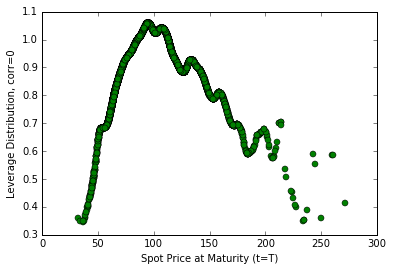

In [85]:
x = np.linspace(0, 200, 101)      

f = interpolate.interp1d(finalS0, finalLev0, kind='cubic', bounds_error=False)

print "Leverage Distribution Values and Interpolated Leverage Function"
#plt.figure(0)
plt.plot(x, f(x))
#plt.xlabel('Spot Price at Maturity (t=T)')
#plt.ylabel('Interpolated (Smoothed) Leverage Function, corr=0')


plt.plot(finalS0, finalLev0, 'o')
plt.xlabel('Spot Price at Maturity (t=T)')
plt.ylabel('Leverage Distribution, corr=0')

** Note: **
    
    Leverage function at corr=0 has the expected 'hump' shape reaching its maximum at/around S0=100.
    

In [86]:
# Bullet 1 continued

#Part 2: Plot vol smile from pure SVM (leverage=1):

# let's get volatility smile for a range of call strikes:

def call_pure_SVM(strike, S0, a0, VoV, corr, T, N2, timesteps):
    
    sPrev=np.full(N2, S0, dtype=np.float)
    aPrev=np.full(N2, a0, dtype=np.float)

    k=1

    dt=T/timesteps
    
    while k<=timesteps:
        
        eS = rnd.normal(0.0,1.0,size=N2)
        eA = rnd.normal(0.0,1.0,size=N2)
    
        # generates N2 samples of stock values and vol process values:

        #log-Euler:
        simA=aPrev*np.exp(-0.5*VoV*VoV*dt + np.sqrt(dt)*VoV*eA)
        simS=sPrev*np.exp(-0.5*aPrev*aPrev*dt + np.sqrt(dt)*aPrev*(corr*eA + np.sqrt(1-corr*corr)*eS))
        
        sPrev=simS
        aPrev=simA
        
        k=k+1
        
    simST=simS
   
    call_i=np.maximum(simST-strike, 0)
    
    return np.mean(call_i)


def vol_smile(K_start, K_end, K_increment, corr, VoV, N2):
    strikes_=[]
    volsSVM_=[]
    K0=K_start
    while K0<=K_end:
        #generate pure SVM call prices:
        strikes_.append(K0)
        call_SVM = call_pure_SVM(K0, S0, a0, VoV, corr, T, N2, timesteps)
    
        impV= blackscholes_impv_scalar(K0, T, S0, call_SVM, r=0, q=0, callput='call', tol=1e-6, maxiter=500)
        volsSVM_.append(impV)
    
        K0=K0+K_increment
        
    return strikes_, volsSVM_


In [87]:
N2=10000
corr0=0.0

K_start=10.0
K_end=200.0
K_increment=10.0

x_val, vol_smile=vol_smile(K_start, K_end, K_increment, corr0, VoV, N2)


Pure SVM (leverage =1): Vol Smile at corr=0


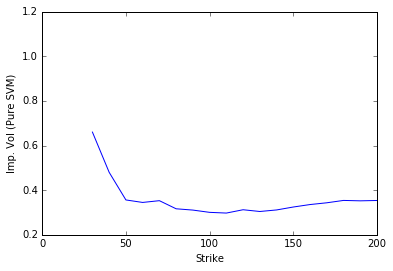

In [88]:
print "Pure SVM (leverage =1): Vol Smile at corr=0"

plt.plot(x_val, vol_smile)
plt.xlabel('Strike')
plt.ylabel('Imp. Vol (Pure SVM)')

# Note: we see some pronounced vol smile - as expected (no market calibration / leverage=1)

** Note: **
    
  The implied vol from pure SVM (leverage set to 1) model exhibits a typical volatility smile as expected. Indeed, we see a prominent vol smile as in such pure SVM model, there is no calibration to market data/no actual market 'smile'/vol dependence on spot and time that we can achieve via the leverage function in the more complex calibrated LSVM model.

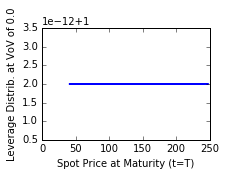

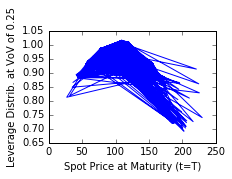

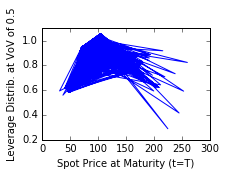

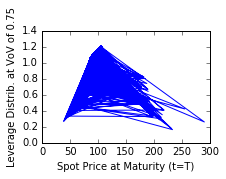

In [89]:
# Bullet 1 continued

# part 3: sensitivity of leverage function (calibrated LVM) to VoV parameter 
# assumed corr=0

corr0=0.0

N1=2000

VoVs=0.0
fig=0

while VoVs<=0.75:
    
    finalSV, finalLevV, _, _, _ = lev_function(corr0, VoVs, S0, a0, T, sigmaDup, N1, timesteps, quar_kern, 1)
 
    plt.figure(fig)
    plt.figure(figsize=(3,2))
    plt.plot(finalSV, finalLevV)
    plt.xlabel('Spot Price at Maturity (t=T)')
    plt.ylabel('Leverage Distrib. at VoV of %r' % VoVs)
    fig=fig+1
    VoVs=VoVs+0.25


# NOTE: to avoid dependence on the interp. assump:
# >> actual leverage distributions (rather than smoothed/interpolated leverage functions) are shown below

**Note:**

The shapes of the leverage distributions/functions shown above are as expected:

When VoV=0 (i.e., constant vol), the leverage function is constant at 1.0 (see above).

At relatively low VoV values, leverage function is relatively flat (as expected as well), and as VoV increases, leverage function/distribution's slope increases.


Vol Smile with Pure SVM (leverage =1) at diff VoV values:


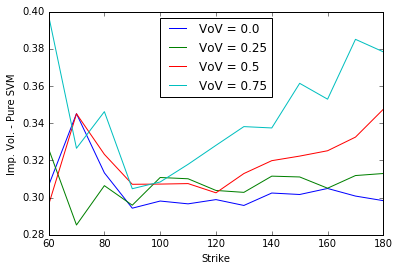

In [90]:
# Bullet 1 continued

# part 3: sensitivity of vol smile (pure SVM, leverage of 1) to VoV parameter 
# assumed corr=0

corr0=0.0

N1=10000

K_start1=60.0
K_end1=180.0
K_increment1=10.0

VoVsk=0.0

def vol_smile2(K_start, K_end, K_increment, corr, VoV, N2):
    strikes_=[]
    volsSVM_=[]
    K0=K_start
    while K0<=K_end:
        #generate pure SVM call prices:
        strikes_.append(K0)
        call_SVM = call_pure_SVM(K0, S0, a0, VoV, corr, T, N2, timesteps)
    
        impV= blackscholes_impv_scalar(K0, T, S0, call_SVM, r=0, q=0, callput='call', tol=1e-6, maxiter=500)
        volsSVM_.append(impV)
    
        K0=K0+K_increment
        
    return strikes_, volsSVM_

print "Vol Smile with Pure SVM (leverage =1) at diff VoV values:"
while VoVsk<=0.75:
    
    x_valVs, vol_smileVs = vol_smile2(K_start1, K_end1, K_increment1, corr0, VoVsk, N1)
 
    #plt.figure(fig)
    #plt.figure(figsize=(8,10))
    plt.plot(x_valVs, vol_smileVs, label='VoV = %r' % VoVsk)
    #plt.xlabel('Stock Price / Strike')
    #plt.ylabel('Imp. Vol. at VoV of %r' % VoVs)
    #fig=fig+1
    VoVsk=VoVsk+0.25
    
plt.xlabel('Strike')
plt.ylabel('Imp. Vol. - Pure SVM')
plt.legend(loc='best')



**NOTE:**

As expected, with pure SVM, we observe vol smiles above (i.e., the imp. vol varies with stock price/strike values in the absence of the calibration to the market as we had done earlier with the leverage function).

Also, not surprisingly, with increase in VoV, the vol smile generally becomes even more clear [compare the vol smile at VoV=0 to the one at VoV=0.75].


## Bullet #2 ##

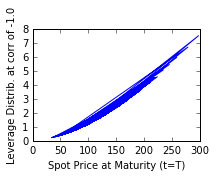

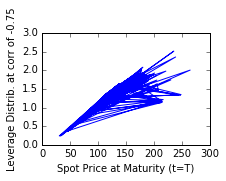

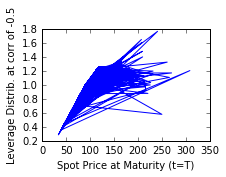

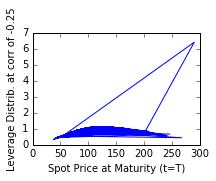

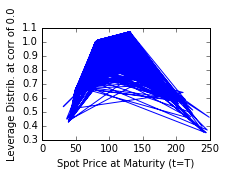

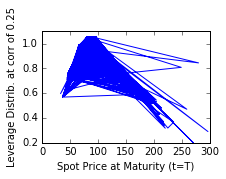

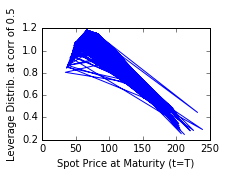

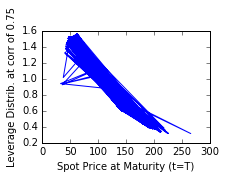

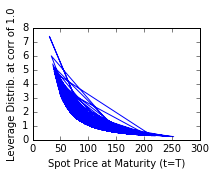

In [91]:
# BULLET #2 - sensitivity to correlation

# Calibrated leverage in LSVM:

VoV=0.5

N1=3000

corrS=-1.0
fig=0

# similar to Bullet 1 above, let's focus on lev distrib/functions at t=T (for simplicity sake):

while corrS<=1.0:
    finalSC, finalLevC, _, _, _ = lev_function(corrS, VoV, S0, a0, T, sigmaDup, N1, timesteps, quar_kern, 1)
    plt.figure(fig)
    plt.figure(figsize=(3,2))
    plt.plot(finalSC, finalLevC)
    plt.xlabel('Spot Price at Maturity (t=T)')
    plt.ylabel('Leverage Distrib. at corr of %r' % corrS)
    fig=fig+1
    corrS=corrS+0.25



**Note:**

The shapes of the leverage distributions/functions shown above are as expected:

With perfect negative correlation, we see that the leverage function is linearly increasing in spot / stock prices:  as spot prices/strikes increase, we see rapidly increasing leverage function values - i.e., the leverage function needs to 'compensate' for the fact that spot price and volatilty processes are negatively correlated, i.e., the leverage 'calibration' function helps to 'pull' the modeled stock price process back to the observed market data.

Similarly, with perfect positive correlation, we see a linearly decreasing leverage function [may not be entirely linear-looking just due to the estimation error]: i.e., as spot prices/strikes increase, we see rapidly decreasing leverage function values - at higher spot prices, vol. will be also higher/both stock and instant. vols will be moving in tandem, thus, the calibrated  leverage function is dropping to low values (no need to 'compensate' / there is lower sensitivity of the spots to the market 'disturbances'/ events at high spot values in that case).


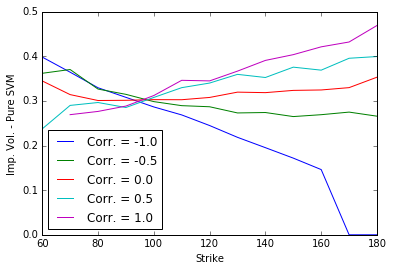

In [92]:
# BULLET #2 continued

# Pure SVM, lev=1:

corrS=-1.0
#fig=0
VoV=0.5

N1=10000

K_start=60.0
K_end=180.0
K_increment=10.0

#fig = plt.figure()
#ax = plt.subplot(111)

def vol_smile3(K_start, K_end, K_increment, corr, VoV, N2):
    strikes_=[]
    volsSVM_=[]
    K0=K_start
    while K0<=K_end:
        #generate pure SVM call prices:
        strikes_.append(K0)
        call_SVM = call_pure_SVM(K0, S0, a0, VoV, corr, T, N2, timesteps)
    
        impV= blackscholes_impv_scalar(K0, T, S0, call_SVM, r=0, q=0, callput='call', tol=1e-6, maxiter=500)
        volsSVM_.append(impV)
    
        K0=K0+K_increment
        
    return strikes_, volsSVM_


while corrS<=1.0:
    pureSC, pureVolC = vol_smile3(K_start, K_end, K_increment, corrS, VoV, N1)
    #plt.figure(fig)
    #plt.figure(figsize=(3,2))
    plt.plot(pureSC, pureVolC, label='Corr. = %r' % corrS)

    #fig=fig+1
    corrS=corrS+0.5

plt.xlabel('Strike')
plt.ylabel('Imp. Vol. - Pure SVM')
plt.legend(loc='best')


** Note re: pure SVM vol smile chart above:**

We see the existence of volatility smiles at all correlation levels; however the volatility smile is most pronounced at higher (either negative or positive) correlations. Moreover, it appears that volatility smile is downward sloping with strike increase at negative correlation levels, and generally upward sloping at the positive correlation levels.
This makes sense: at positive correlations between stock and vol process, the implied vol tends to be high in case of out of money options/calls (higher uncertainty 'exacerbated' by the positive correlation between two processes) - and vice versa for sizable negative correlation between the stock and vol processes (in that latter case, stock and vol processes tend to move in opposite directions over time / 'counterbalancing' (and in a way 'diversifying') each other, which has some dampening effect on the implied volatility.

## Bullet #3  [forward-starting call spread]##


In [93]:
# BULLET #3 - FORWARD-STARTING CALL SPREAD


T1=1.0-1.0/12.0

T2=T
K1=0.95
K2=1.05

VoV=0.5
corr=-0.5

volBS=0.3



In [94]:
# THIS IS A VERY ROUGH Approx. Adjusted BS Option PRICING FORMULA -NOT ACTUALLY USED/ JUST FOR CHECKING PURPOSES/
# SEE M-C SIMULATION BELOW for the ACTUAL ANSWER / I.E., HOW TO GET B-S PRICE WITH CONSTANT VOL=0.3

# modified B-S function to evaluate ratios of spots at T

def blackscholes_price_ratio(K, T1, T2, S0, volBS, r=0, q=0, callput='call'):
    F1 = S0*np.exp((r-q)*T1)
    F2 = S0*np.exp((r-q)*T2)
    
    w1 = volBS**2*T1
    w2 = volBS**2*T2
    
    F=F2/F1
    
    d1 = (np.log(F/K)+0.5*w2)/np.sqrt(w2)
    d2 = d1 - np.sqrt(w2)
    
    callput = callput.lower()
    if callput == 'call':
        opttype = 1
    elif callput == 'put':
        opttype = -1
    else:
        raise ValueError('The value of callput must be either "call" or "put".')
    price = (opttype*F*norm.cdf(opttype*d1)-opttype*K*norm.cdf(opttype*(d2)))*np.exp(-r*T2)
    return price

# NOT USED - FOR CHECKING /TESTING PURPOSES
# ROUGH ESTIMATE USIGN APPROX MODIFICATION OF B-S OPTION PRICING FORMULA

# Est. Black-Scholes spread price:

#rough_BSlong=blackscholes_price_ratio(K1, T1, T2, S0, volBS, r=0, q=0, callput='call')
#rough_BSshort=blackscholes_price_ratio(K2, T1, T2, S0, volBS, r=0, q=0, callput='call')
#roughBS=rough_BSlong-rough_BSshort
#print roughBS

In [95]:
# continued bullet 3:

# Black-Scholes-type stock path generator (used as the foundation for Bullet 3 below):

def blackscholes_mc(S0=100, vol=0.2, r=0, q=0, timesteps=np.linspace(0, 1, 13), npaths=10):
    """Generate Monte-Carlo paths in Black-Scholes model.

    Parameters
    ----------
    S: scalar
        The spot level of the underlying security
    vol: scalar
        Volatility
    r: scalar
        Interest rate
    q: scalar
        Dividend yield
    timesteps: array_like
        The time steps of the simualtion
    npaths: int
        the number of paths to simulate

    Returns
    -------
    paths: ndarray
        The Monte-Carlo paths.
    """
    nsteps = len(timesteps) - 1
    ts = np.asfarray(timesteps)[:, np.newaxis]
    W = np.cumsum(np.vstack((np.zeros((1, npaths), dtype=np.float),
                             np.random.randn(nsteps, npaths) * np.sqrt(np.diff(ts, axis=0)))),
                  axis=0)
    paths = np.exp(-0.5*vol**2*ts + vol*W)*S0*np.exp((r-q)*ts)
    return paths


In [96]:
# continued BULLET #3: PRICE THE SPREAD USING B-S PRICING VIA MONTE CARLO, CONSTANT VOL=30%

# generate stock paths from time 0 to final maturity of 1 year, with 1 month increments:

N2=100000
ts = np.linspace(0, T2, int(np.round(T2*12))+1)

def call_ratio_BS(K1, K2, S0, volBS, N2, timesteps=ts): 
    paths = blackscholes_mc(S0=S0, vol=volBS, r=0, q=0, timesteps=ts, npaths=N2)

    ST2=paths[-1]
    ST1=paths[-2]

    # price the call spread:

    callBS_long=np.mean(np.maximum(ST2/ST1 - K1, 0))
    callBS_short=np.mean(np.maximum(ST2/ST1 - K2, 0))

    callBS_spread=callBS_long - callBS_short
    
    return callBS_spread

print call_ratio_BS(K1, K2, S0, volBS, N2, timesteps=ts)


0.0486961325117


In [100]:
# Pricing the call spread using the PURE SVM MODEL:

N2=100000
timesteps=100

def call_ratio_SVM(strike, S0, a0, corr, VoV, T1, T2, sprices, N2, timesteps):
    
    sPrev=np.full(N2, S0, dtype=np.float)
    aPrev=np.full(N2, a0, dtype=np.float)

    k=1

    dt=T/timesteps
    
    while k<=(timesteps-1):
        
        eS = rnd.normal(0.0,1.0,size=N2)
        eA = rnd.normal(0.0,1.0,size=N2)
    
        # generates N2 samples of stock values and vol process values:
        
        lev=1.0
        
        #log-Euler:
        simA=aPrev*np.exp(-0.5*VoV*VoV*dt + np.sqrt(dt)*VoV*eA)
        simS=sPrev*np.exp(-0.5*aPrev*aPrev*lev*lev*dt + np.sqrt(dt)*lev*aPrev*(corr*eA + np.sqrt(1-corr*corr)*eS))
        
        sPrev=simS
        aPrev=simA
        
        k=k+1
        
    # stock prices at T1:    
    simS_T1=simS
   
    # final step to generate stock prices at T2:
    eS = rnd.normal(0.0,1.0,size=N2)
    eA = rnd.normal(0.0,1.0,size=N2)
        
    
    #log-Euler:
    simA=aPrev*np.exp(-0.5*VoV*VoV*dt + np.sqrt(dt)*VoV*eA)
    simS=simS_T1*np.exp(-0.5*aPrev*aPrev*lev*lev*dt + np.sqrt(dt)*lev*aPrev*(corr*eA + np.sqrt(1-corr*corr)*eS))
        
    # stock price at T2:
    simS_T2=simS
    
    call_i=np.maximum(simS_T2/simS_T1-strike, 0)
    
    return np.mean(call_i)


In [101]:
# price the call spread using a pure SVM:

callSVM_long=call_ratio_SVM(K1, S0, a0, corr, VoV, T1, T2, sprices, N2, timesteps)
callSVM_short=call_ratio_SVM(K2, S0, a0, corr, VoV, T1, T2, sprices, N2, timesteps)

callSVM_spread=callSVM_long - callSVM_short

print callSVM_spread

0.049731223146


In [97]:
# Bullet #3 continued

# Pricing the call spread using the CALIBRATED LEVERAGE LSVM MODEL:

N2=100000
timesteps=100

def call_ratio_LVM(strike, S0, a0, corr, VoV, T1, T2, leverage, sprices, N2, timesteps):
    
    sPrev=np.full(N2, S0, dtype=np.float)
    aPrev=np.full(N2, a0, dtype=np.float)

    k=1

    dt=T/timesteps
    
    while k<=(timesteps-1):
        
        eS = rnd.normal(0.0,1.0,size=N2)
        eA = rnd.normal(0.0,1.0,size=N2)
    
        # generates N2 samples of stock values and vol process values:
        # uses prior leverage function values (generated by leverage function) - lookup by stock price 
        # uses linear interp. to speed this up 
        
        lev=np.interp(sPrev,sprices[k-1],leverage[k-1])
        
        #log-Euler:
        simA=aPrev*np.exp(-0.5*VoV*VoV*dt + np.sqrt(dt)*VoV*eA)
        simS=sPrev*np.exp(-0.5*aPrev*aPrev*lev*lev*dt + np.sqrt(dt)*lev*aPrev*(corr*eA + np.sqrt(1-corr*corr)*eS))
        
        sPrev=simS
        aPrev=simA
        
        k=k+1
        
    # stock prices at T1:    
    simS_T1=simS
   
    # final step to generate stock prices at T2:
    eS = rnd.normal(0.0,1.0,size=N2)
    eA = rnd.normal(0.0,1.0,size=N2)
        
    lev=np.interp(sPrev,sprices[k-1],leverage[k-1])
    
    #log-Euler:
    simA=aPrev*np.exp(-0.5*VoV*VoV*dt + np.sqrt(dt)*VoV*eA)
    simS=simS_T1*np.exp(-0.5*aPrev*aPrev*lev*lev*dt + np.sqrt(dt)*lev*aPrev*(corr*eA + np.sqrt(1-corr*corr)*eS))
        
    # stock price at T2:
    simS_T2=simS
    
    call_i=np.maximum(simS_T2/simS_T1-strike, 0)
    
    return np.mean(call_i)


In [98]:
# price the call spread using LVM:

callLVM_long=call_ratio_LVM(K1, S0, a0, corr, VoV, T1, T2, leverage, sprices, N2, timesteps)
callLVM_short=call_ratio_LVM(K2, S0, a0, corr, VoV, T1, T2, leverage, sprices, N2, timesteps)

callLVM_spread=callLVM_long - callLVM_short

print callLVM_spread


0.0500026832081


BS estimation variance:
1.13515827006e-09

Pure SVM estimation variance:
1.07751885818e-09

LSVM estimation variance:
6.84560071368e-10

Compare values between BS, pure SVM and LSVM call spread estimation:


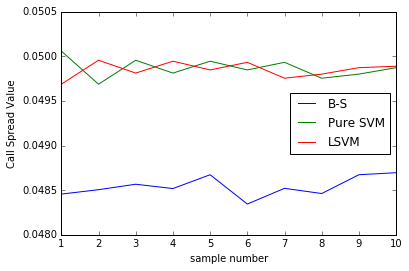

In [105]:
# Mean batched estimator: compare the BS prices with pure SVM and LSVM prices based on 10 indep. samples:

N2=100000

sample=1
nbatch=10

BS_values=[]
SVM_values=[]
LVM_values=[]

samples=[]

while sample<=nbatch:
    
    bs_temp=call_ratio_BS(K1, K2, S0, volBS, N2, timesteps=ts)
    
    BS_values.append(bs_temp)
    
    svm_temp=call_ratio_SVM(K1, S0, a0, corr, VoV, T1, T2, sprices, N2, timesteps) - call_ratio_SVM(K2, S0, a0, corr, VoV, T1, T2, sprices, N2, timesteps)    
    SVM_values.append(lvm_temp)
    
    lvm_temp=call_ratio_LVM(K1, S0, a0, corr, VoV, T1, T2, leverage, sprices, N2, timesteps) - call_ratio_LVM(K2, S0, a0, corr, VoV, T1, T2, leverage, sprices, N2, timesteps)
    LVM_values.append(lvm_temp)
    
    samples.append(sample)
    sample=sample+1

bs=np.asarray(BS_values)
svm=np.asarray(SVM_values)
lvm=np.asarray(LVM_values)

print("BS estimation variance:")
print np.var(bs)/nbatch

print
print("Pure SVM estimation variance:")
print np.var(svm)/nbatch

print
print("LSVM estimation variance:")
print np.var(lvm)/nbatch

print 
print "Compare values between BS, pure SVM and LSVM call spread estimation:"

plt.plot(samples, bs, '-b', label='B-S')
plt.plot(samples, svm, '-g', label='Pure SVM')
plt.plot(samples, lvm, '-r', label='LSVM')

plt.legend(loc='best')
plt.xlabel('sample number')
plt.ylabel('Call Spread Value')

** Comparison to Model Benchmarks: BS Model**

Call spread prices are fairly similar [same order of magnitude] between B-S model with constant volBS=30% and calibated LSVM model. 
However, LSVM model tends to produce a somewhat higher call spread price (and consistently so; see the chart above for the comparison of call spread prices across different indep. samples), implying there is a slight **forward volatility skew** (as LSVM does not assume a constant vol, it allows us to capture this forward skew in volatility unlike a much simpler, constant-vol B-S model).


** Comparison to Model Benchmarks: a pure SVM and overall conclusion**

Call spread prices are fairly similar [same order of magnitude] between a pure SVM model and calibated LSVM model. 
However, LSVM model results in a more stable estimate (note that the LSVM estimation variance is sizably lower as compared to the pure SVM estimation variance), and a more realistic pattern of the **forward volatility skew** (as LSVM is better suited to capture the actual forward volatility than a simpler (and non-calibrated) pure SVM).

Calibrated LSVMs are thus better suited to capture the actual market/dynamics as compared to simpler models such as BS and SVM.

Also, unlike simpler "static" models such as BS and even 'pure' SVM, these models are more flexible / can be easily modified to price more complex (path-dependent) derivatives i.e., **at varying market conditions**.
    